In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import pmdarima.arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('Impute_misvalues_hungyen.csv')
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,0,47.0
1,1/1/2008,1,43.0
2,1/1/2008,2,40.0
3,1/1/2008,3,37.0
4,1/1/2008,4,34.0


In [3]:
df['Hour'] = df['Hour'].replace('#NUM!', 0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64061 entries, 0 to 64060
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        64061 non-null  object 
 1   Hour        64061 non-null  object 
 2   Waterlevel  64061 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB


In [5]:
df.describe()

,Waterlevel
count,64061.000000
mean,138.135113
std,97.020489
min,-26.000000
25%,75.000000
50%,116.000000
75%,171.000000
max,651.000000


In [6]:
df.isnull().sum()

Date          0
Hour          0
Waterlevel    0
dtype: int64

In [7]:
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,00:00:00,47.0
1,1/1/2008,01:00:00,43.0
2,1/1/2008,02:00:00,40.0
3,1/1/2008,03:00:00,37.0
4,1/1/2008,04:00:00,34.0


In [8]:
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], axis = 1, inplace = True)

df.head()

,Waterlevel
DateTime,
2008-01-01 00:00:00,47.0
2008-01-01 01:00:00,43.0
2008-01-01 02:00:00,40.0
2008-01-01 03:00:00,37.0
2008-01-01 04:00:00,34.0


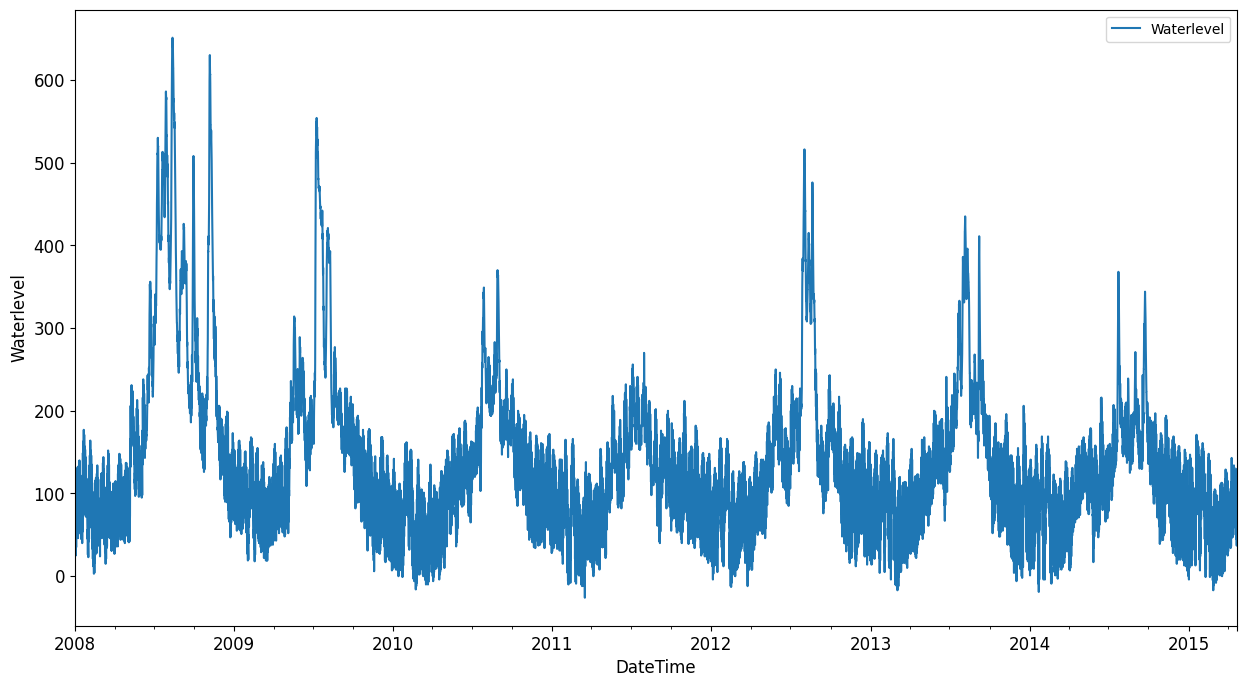

In [9]:
df.plot(y='Waterlevel', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)
plt.show()

In [10]:
train_size = int(len(df) * 0.7)
train, test = df[:train_size].iloc[:, [-1]], df[train_size:].iloc[:, [-1]]

train, test

(                     Waterlevel
 DateTime                       
 2008-01-01 00:00:00        47.0
 2008-01-01 01:00:00        43.0
 2008-01-01 02:00:00        40.0
 2008-01-01 03:00:00        37.0
 2008-01-01 04:00:00        34.0
 ...                         ...
 2013-02-11 05:00:00        86.0
 2013-02-11 06:00:00       100.0
 2013-02-11 07:00:00       115.0
 2013-02-11 08:00:00       128.0
 2013-02-11 09:00:00       134.0
 
 [44842 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2013-02-11 10:00:00       133.0
 2013-02-11 11:00:00       127.0
 2013-02-11 12:00:00       122.0
 2013-02-11 13:00:00       115.0
 2013-02-11 14:00:00       107.0
 ...                         ...
 2015-04-23 00:00:00       127.0
 2015-04-23 01:00:00       124.0
 2015-04-23 02:00:00       120.0
 2015-04-23 03:00:00       115.0
 2015-04-23 04:00:00       109.0
 
 [19219 rows x 1 columns])

In [11]:
train.shape, test.shape

((44842, 1), (19219, 1))

Text(0, 0.5, 'Waterlevel')

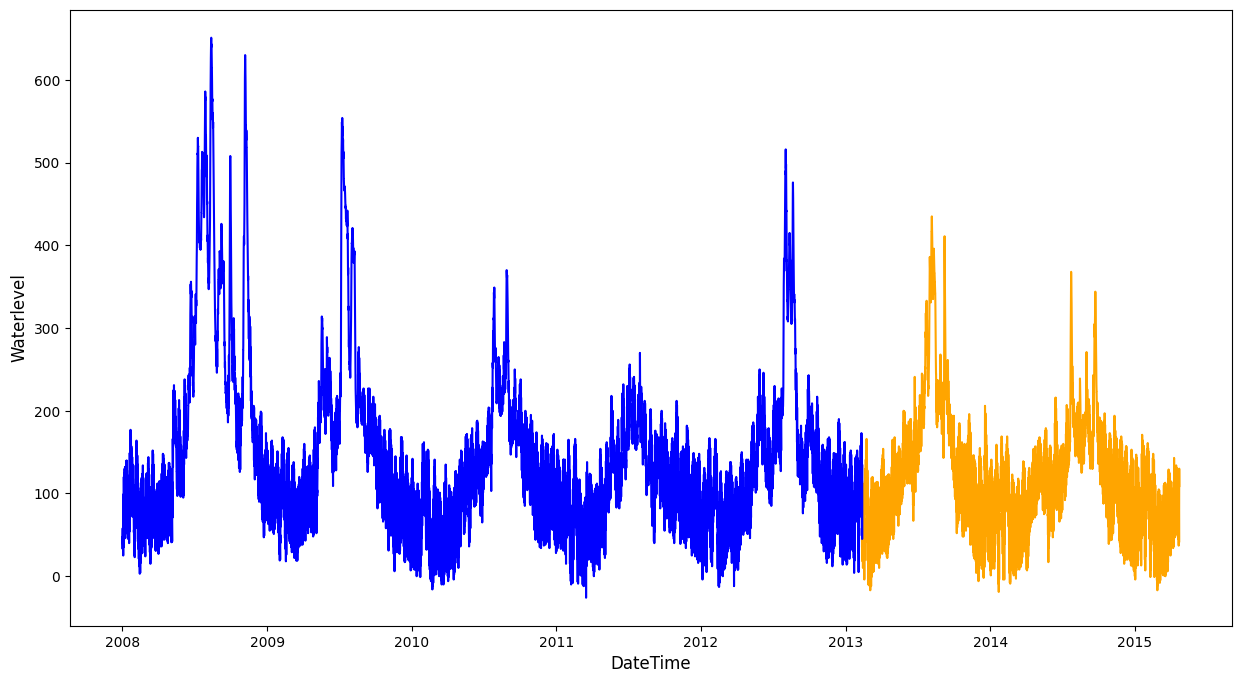

In [12]:
plt.figure(figsize = (15,8))
plt.plot(test.index, test['Waterlevel'], label = "test", color = 'orange')
plt.plot(train.index, train['Waterlevel'], label = "train" , color = 'blue')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)

In [13]:
scaler = MinMaxScaler()
train['Waterlevel'] = scaler.fit_transform(train)
test['Waterlevel'] = scaler.transform(test)

In [14]:
train_data = train.values
test_data = test.values

In [15]:
timesteps = 164


In [16]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


In [17]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

x_train, y_train

(array([[0.10782866, 0.10192024, 0.09748892, ..., 0.17282127, 0.16395864,
         0.15509601],
        [0.10192024, 0.09748892, 0.09305761, ..., 0.16395864, 0.15509601,
         0.14623338],
        [0.09748892, 0.09305761, 0.08862629, ..., 0.15509601, 0.14623338,
         0.13737075],
        ...,
        [0.1816839 , 0.17725258, 0.17282127, ..., 0.14327917, 0.16543575,
         0.18611521],
        [0.17725258, 0.17282127, 0.16838996, ..., 0.16543575, 0.18611521,
         0.20827179],
        [0.17282127, 0.16838996, 0.16395864, ..., 0.18611521, 0.20827179,
         0.22747415]]),
 array([[0.14623338],
        [0.13737075],
        [0.12998523],
        ...,
        [0.20827179],
        [0.22747415],
        [0.23633678]]))

In [18]:
x_train.shape, y_train.shape

((44679, 163), (44679, 1))

In [19]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r, _ = pearsonr(y_true, y_pred)
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R': r,
        'SIM': sim,
        'FSD': fsd,
        'NSE': nse
    }

# SVR

In [20]:
model_SVR = SVR(kernel='rbf',gamma=0.01, C=50, epsilon = 0.005)
model_SVR.fit(x_train, y_train[:,0])

SVR(C=50, epsilon=0.005, gamma=0.01)

In [21]:
hours = 120
def forecast_value (model, hours):
    current_window = x_train[-1,:].tolist()

    predict = []

    for _ in range(hours):
        next_value = model.predict([current_window])[0]
        predict.append(next_value)
        
        current_window.pop(0)  
        current_window.append(next_value)
    predict_array = np.array(predict).reshape(-1, 1)
    return(predict_array)
predict_SVR = forecast_value(model_SVR, hours)    

In [22]:
y_test_pred = scaler.inverse_transform(predict_SVR)
y_train_original = scaler.inverse_transform(y_train)
y_test_original = scaler.inverse_transform(test)

print(len(y_test_pred), len(y_train_original), len(y_test_original))

120 44679 19219


In [23]:
train_timestamps = train.index[timesteps-1:]
test_timestamps = test.index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

44679 19056


In [24]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    metrics_SVR = calculate_metrics(y_test_original[:hours].flatten(), y_test_pred[:hours].flatten())
    for metric, value in metrics_SVR.items():
        print(f'Using model SVR {hours} hours {metric}: {value}')

Using model SVR 3 hours MAE: 9.179377482641845
Using model SVR 3 hours RMSE: 10.199165919523216
Using model SVR 3 hours R: 0.18975965397684655
Using model SVR 3 hours SIM: 0.5777978220062454
Using model SVR 3 hours FSD: 1.711394452308725
Using model SVR 3 hours NSE: -4.143993786185026
Using model SVR 6 hours MAE: 12.240911619970978
Using model SVR 6 hours RMSE: 13.01768482922256
Using model SVR 6 hours R: 0.9575027649363759
Using model SVR 6 hours SIM: 0.7431366649611942
Using model SVR 6 hours FSD: 1.9487722952382327
Using model SVR 6 hours NSE: -0.2570707313552367
Using model SVR 12 hours MAE: 15.099147641761748
Using model SVR 12 hours RMSE: 15.69229198702494
Using model SVR 12 hours R: 0.9946615760408626
Using model SVR 12 hours SIM: 0.8508415117292717
Using model SVR 12 hours FSD: 1.982306294399539
Using model SVR 12 hours NSE: 0.6708005755552077
Using model SVR 24 hours MAE: 13.553437241773784
Using model SVR 24 hours RMSE: 15.078160325783582
Using model SVR 24 hours R: 0.9674811

# KNN

In [25]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(x_train, y_train[:,0])

KNeighborsRegressor()

In [26]:
predict_KNN = forecast_value(knn_regressor, hours)

In [27]:
y_test_pred_knn = scaler.inverse_transform(predict_KNN)

In [28]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    metrics_KNN = calculate_metrics(y_test_original[:hours].flatten(), y_test_pred_knn[:hours].flatten())
    for metric, value in metrics_KNN.items():
        print(f'Using model KNN {hours} hours {metric}: {value}')

Using model KNN 3 hours MAE: 13.133333333333326
Using model KNN 3 hours RMSE: 15.351438586225935
Using model KNN 3 hours R: -0.966189221216889
Using model KNN 3 hours SIM: 0.522422102049075
Using model KNN 3 hours FSD: 1.8823749355501553
Using model KNN 3 hours NSE: -10.653846153846148
Using model KNN 6 hours MAE: 19.833333333333332
Using model KNN 6 hours RMSE: 21.70975203297664
Using model KNN 6 hours R: 0.6835384266037678
Using model KNN 6 hours SIM: 0.6530895288196455
Using model KNN 6 hours FSD: 1.9233947670722353
Using model KNN 6 hours NSE: -2.496245621265197
Using model KNN 12 hours MAE: 26.50833333333333
Using model KNN 12 hours RMSE: 28.1368234407037
Using model KNN 12 hours R: 0.9752023994088996
Using model KNN 12 hours SIM: 0.7684810696086709
Using model KNN 12 hours FSD: 1.9781791879948971
Using model KNN 12 hours NSE: -0.058367358306642636
Using model KNN 24 hours MAE: 20.941666666666666
Using model KNN 24 hours RMSE: 24.98961450949841
Using model KNN 24 hours R: 0.915222

# RF

In [29]:
model_RF = RandomForestRegressor(n_estimators=300, max_features=4, random_state=42)

x_train = scaler.inverse_transform(x_train)
y_train = scaler.inverse_transform(y_train)
x_test = scaler.inverse_transform(x_test)
y_test = scaler.inverse_transform(y_test)

model_RF.fit(x_train, y_train[:,0])

RandomForestRegressor(max_features=4, n_estimators=300, random_state=42)

In [30]:
predict_RF = forecast_value(model_RF, hours)

In [31]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast: 
    metrics_RF = calculate_metrics(y_test_original[:hours].flatten(), predict_RF[:hours].flatten())
    for metric, value in metrics_RF.items():
        print(f'Using model RF {hours} hours {metric}: {value}')

Using model RF 3 hours MAE: 10.284999999999997
Using model RF 3 hours RMSE: 11.773671073864577
Using model RF 3 hours R: -0.7215771958742768
Using model RF 3 hours SIM: 0.5646426567378224
Using model RF 3 hours FSD: 1.915051436020128
Using model RF 3 hours NSE: -5.854802060439557
Using model RF 6 hours MAE: 15.262500000000001
Using model RF 6 hours RMSE: 16.597914262652715
Using model RF 6 hours R: 0.8977813424083678
Using model RF 6 hours SIM: 0.7045947937383362
Using model RF 6 hours FSD: 1.6753894470164445
Using model RF 6 hours NSE: -1.04361576001099
Using model RF 12 hours MAE: 22.086388888888887
Using model RF 12 hours RMSE: 23.71152802143107
Using model RF 12 hours R: 0.9898559464176935
Using model RF 12 hours SIM: 0.7992972534782979
Using model RF 12 hours FSD: 1.1536459209389205
Using model RF 12 hours NSE: 0.2483677779325072
Using model RF 24 hours MAE: 19.159652777777776
Using model RF 24 hours RMSE: 22.868779403633177
Using model RF 24 hours R: 0.9334303612049626
Using mode

## ARIMA

In [32]:
train_ARIMA = scaler.inverse_transform(train_data)
test_ARIMA = scaler.inverse_transform(test_data)
train_ARIMA.shape
test_ARIMA.shape

(19219, 1)

In [33]:
warnings.filterwarnings(category=UserWarning, action='ignore')
arima_model = pmdarima.arima.auto_arima(train_ARIMA, seasonal=False, 
                                        error_action='ignore', trace=True,
                                        suppress_warnings=True, maxiter=20, stepwise=True,
                                        n_jobs=2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=200980.726, Time=19.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=289610.714, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=216400.279, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=248451.402, Time=4.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=289608.719, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=207092.816, Time=6.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=201845.967, Time=16.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=201859.951, Time=20.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=200607.340, Time=23.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=206436.578, Time=10.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=200572.517, Time=22.00 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=200280.772, Time=23.55 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=22.11 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=200378.544, Time=24.98 sec
 AR

In [34]:
arima_model.fit(train_ARIMA)

ARIMA(maxiter=20, order=(5, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [35]:
n_periods = len(test_ARIMA)  # or any integer value you want to use
predictions_arima = arima_model.predict(start = len(train_ARIMA.flatten()),
                                        end = len(test_ARIMA.flatten()),
                                        n_periods = 120)
predictions_arima.shape

(120,)

In [36]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    metrics_ARIMA = calculate_metrics(y_test_original[:hours].flatten(), predictions_arima[:hours].flatten())
    for metric, value in metrics_ARIMA.items():
        print(f'Using model ARIMA {hours} hours {metric}: {value}')

Using model ARIMA 3 hours MAE: 6.315453688143606
Using model ARIMA 3 hours RMSE: 6.7654131821934795
Using model ARIMA 3 hours R: 0.9611871481923132
Using model ARIMA 3 hours SIM: 0.6491621905581079
Using model ARIMA 3 hours FSD: 1.8797236897547338
Using model ARIMA 3 hours NSE: -1.263391976550416
Using model ARIMA 6 hours MAE: 8.783378322987309
Using model ARIMA 6 hours RMSE: 9.294371239416954
Using model ARIMA 6 hours R: 0.9904512786839077
Using model ARIMA 6 hours SIM: 0.7990178082365388
Using model ARIMA 6 hours FSD: 1.5601999830731155
Using model ARIMA 6 hours NSE: 0.3591856331136126
Using model ARIMA 12 hours MAE: 13.43977774356974
Using model ARIMA 12 hours RMSE: 15.000594475756836
Using model ARIMA 12 hours R: 0.9936723007950012
Using model ARIMA 12 hours SIM: 0.8672580192320668
Using model ARIMA 12 hours FSD: 1.089697425944931
Using model ARIMA 12 hours NSE: 0.69918239626645
Using model ARIMA 24 hours MAE: 27.07283134009391
Using model ARIMA 24 hours RMSE: 33.29492417282395
Usi

In [37]:
y_test_flat = y_test_original.flatten()
y_test_pred_flat_KNN = y_test_pred_knn.flatten()
y_test_pred_flat_SVR = y_test_pred.flatten()
y_test_pred_flat_RF = predict_RF.flatten()
predictions_arima_flat = predictions_arima.flatten()

df = pd.DataFrame({'Actual': y_test_flat[:hours], 
                   'KNN': y_test_pred_flat_KNN,
                   'SVR': y_test_pred_flat_SVR,
                   'RF': y_test_pred_flat_RF,
                   'ARIMA' : predictions_arima_flat[:hours],}, 
                  index=test_timestamps[:hours])

df

,Actual,KNN,SVR,RF,ARIMA
DateTime,,,,,
2013-02-18 05:00:00,133.0,135.6,135.976440,135.498333,135.962633
2013-02-18 06:00:00,127.0,142.0,138.394454,139.233333,134.361203
2013-02-18 07:00:00,122.0,143.8,135.167239,138.123333,130.622526
2013-02-18 08:00:00,115.0,139.4,129.266655,132.963333,125.353107
2013-02-18 09:00:00,107.0,133.6,122.278160,127.966667,118.616775
...,...,...,...,...,...
2013-02-23 00:00:00,13.0,15.8,88.934930,76.735000,97.338872
2013-02-23 01:00:00,15.0,16.2,90.917079,75.855000,97.354458
2013-02-23 02:00:00,18.0,20.0,93.784753,73.918333,97.361617


In [38]:
train_ARIMA.shape

(44842, 1)

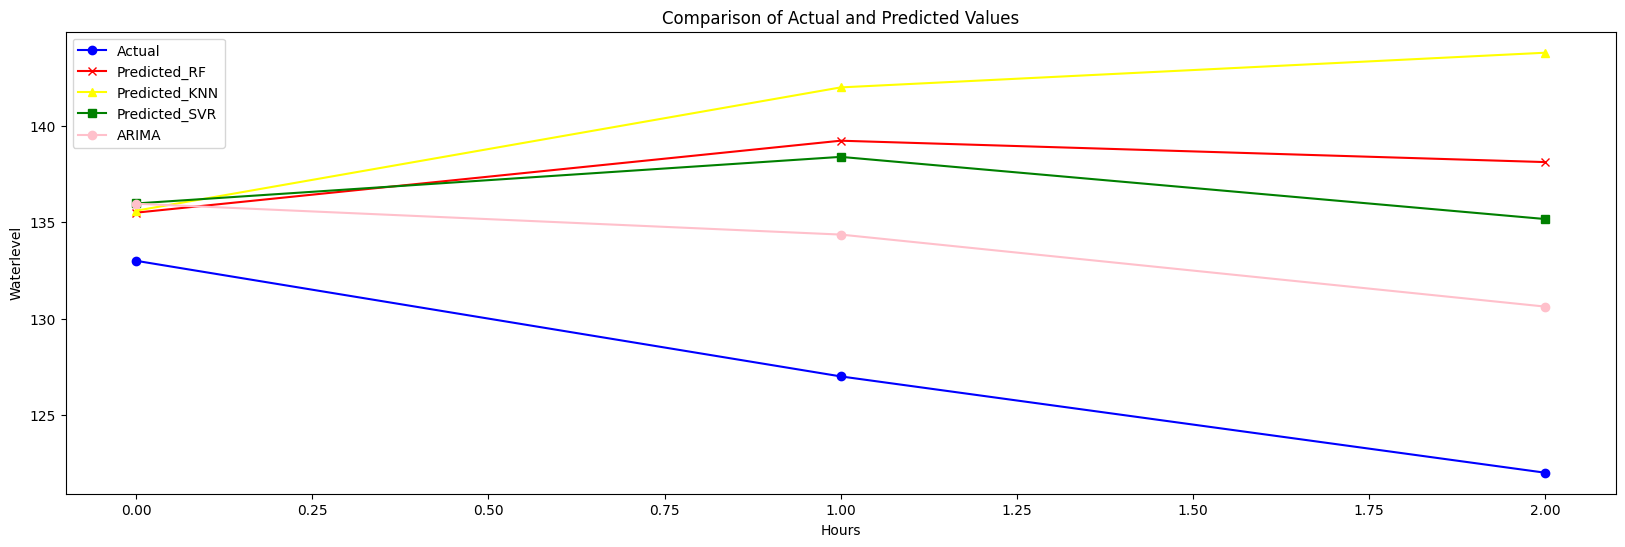

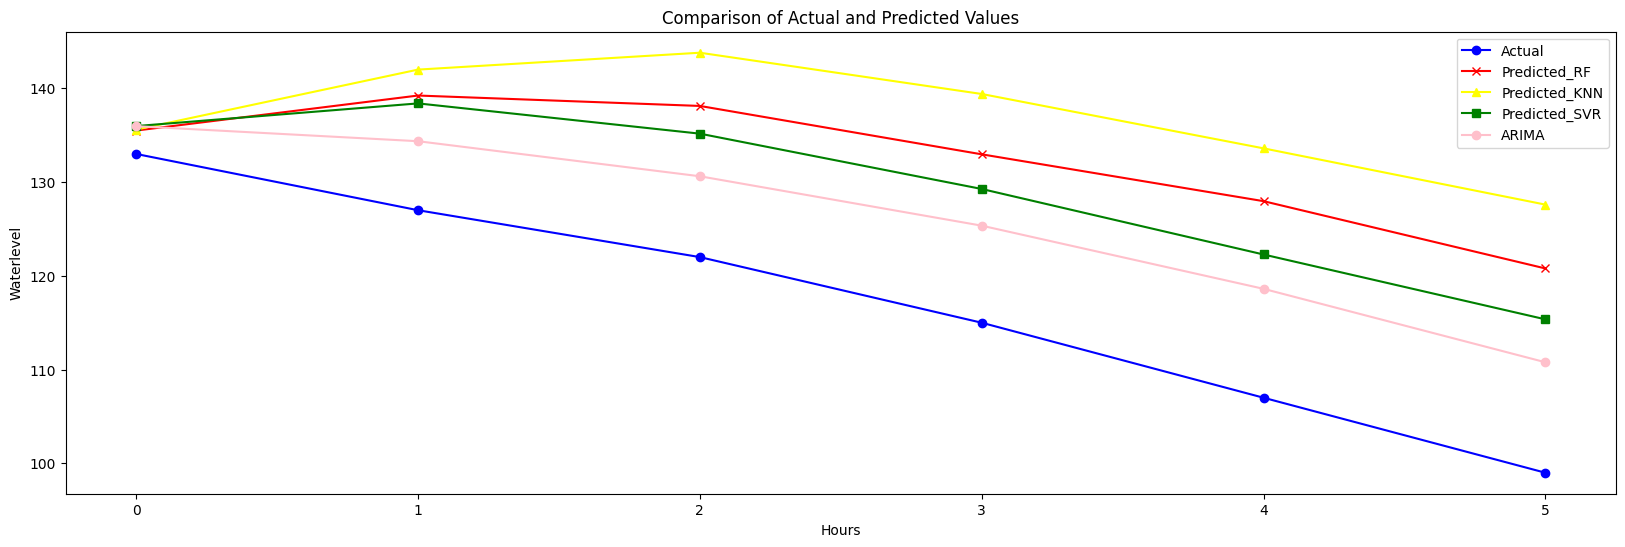

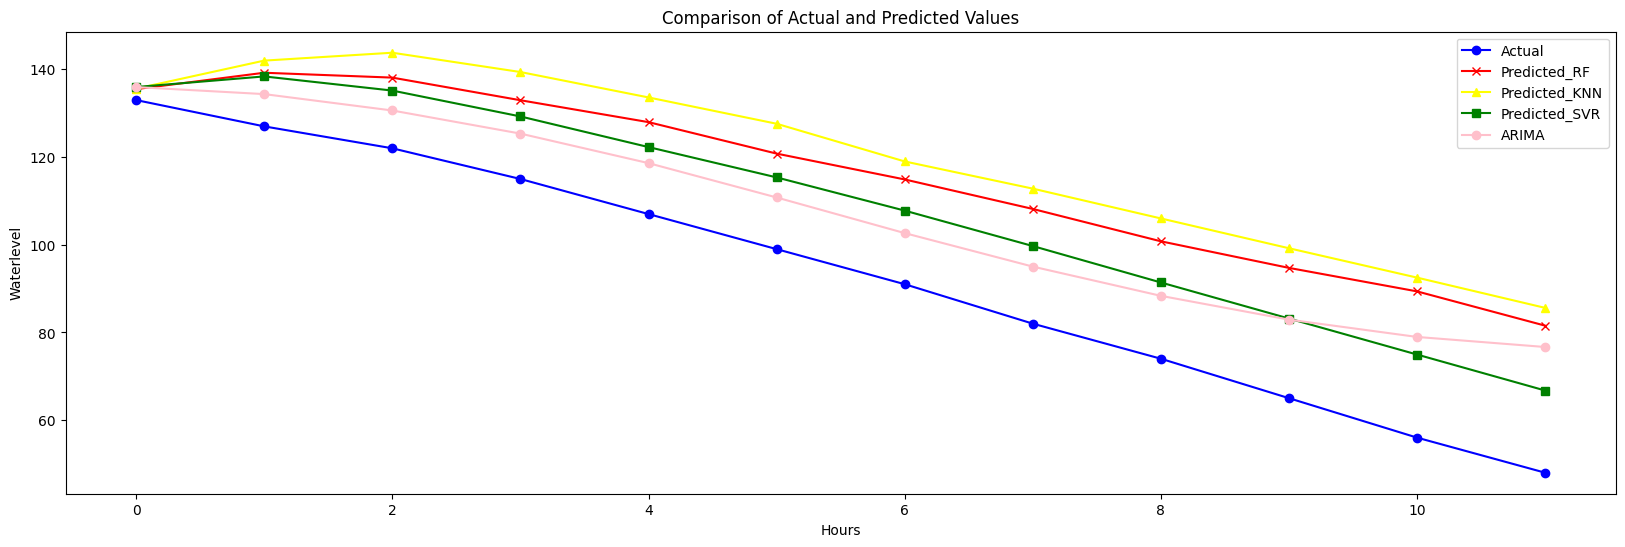

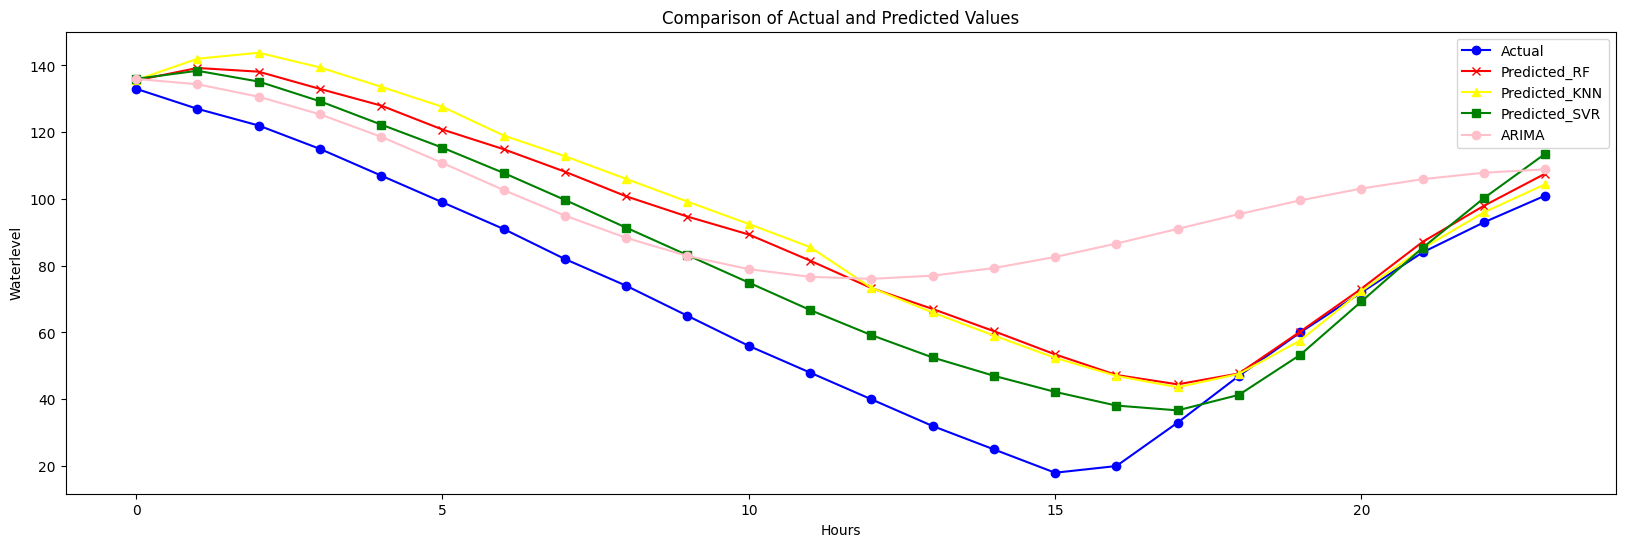

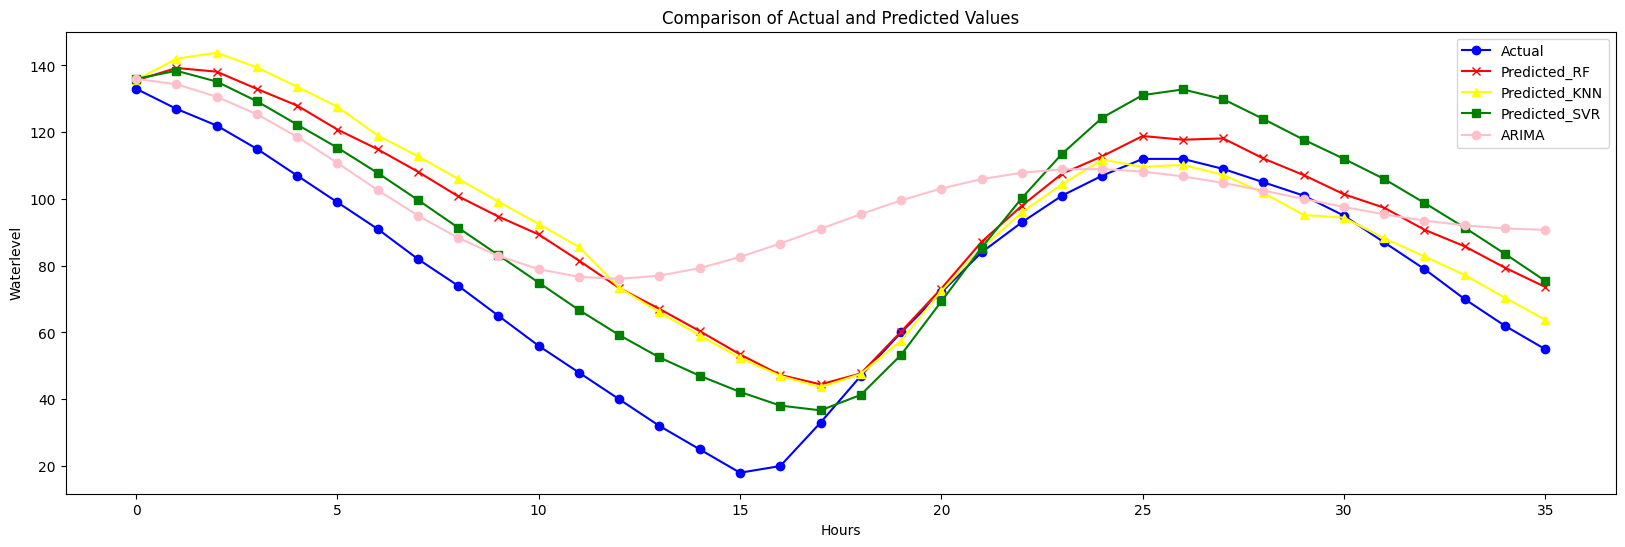

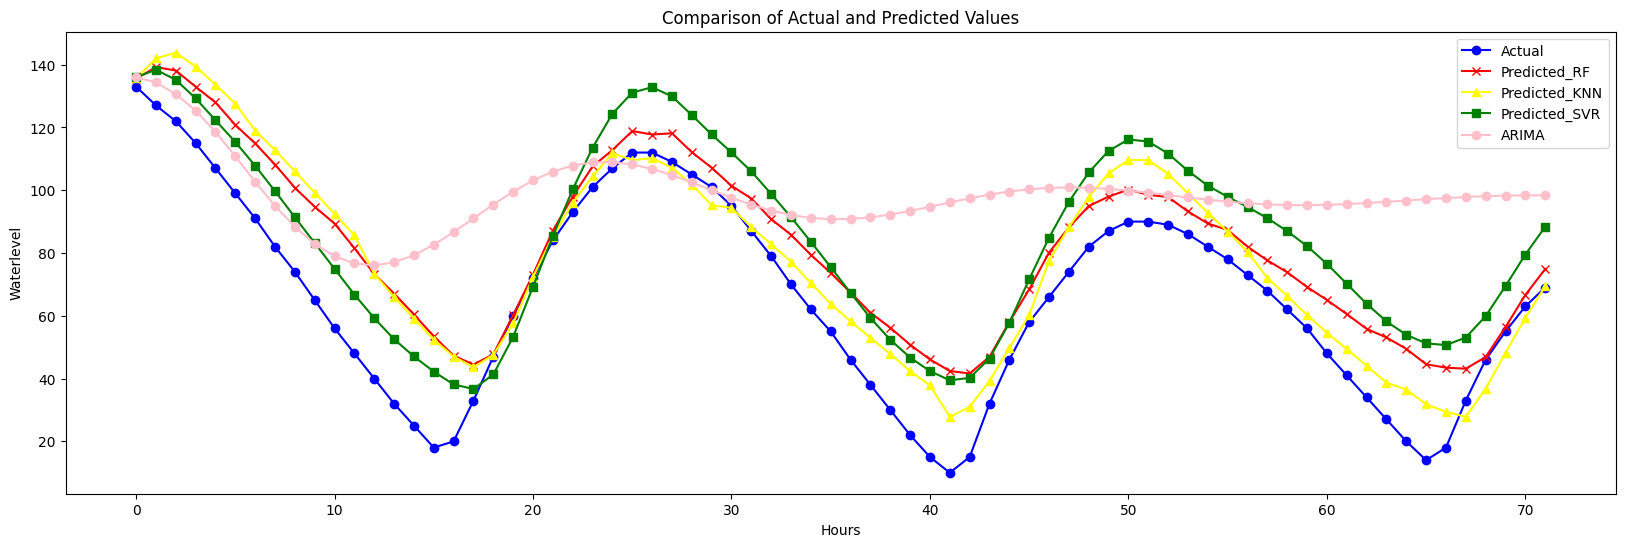

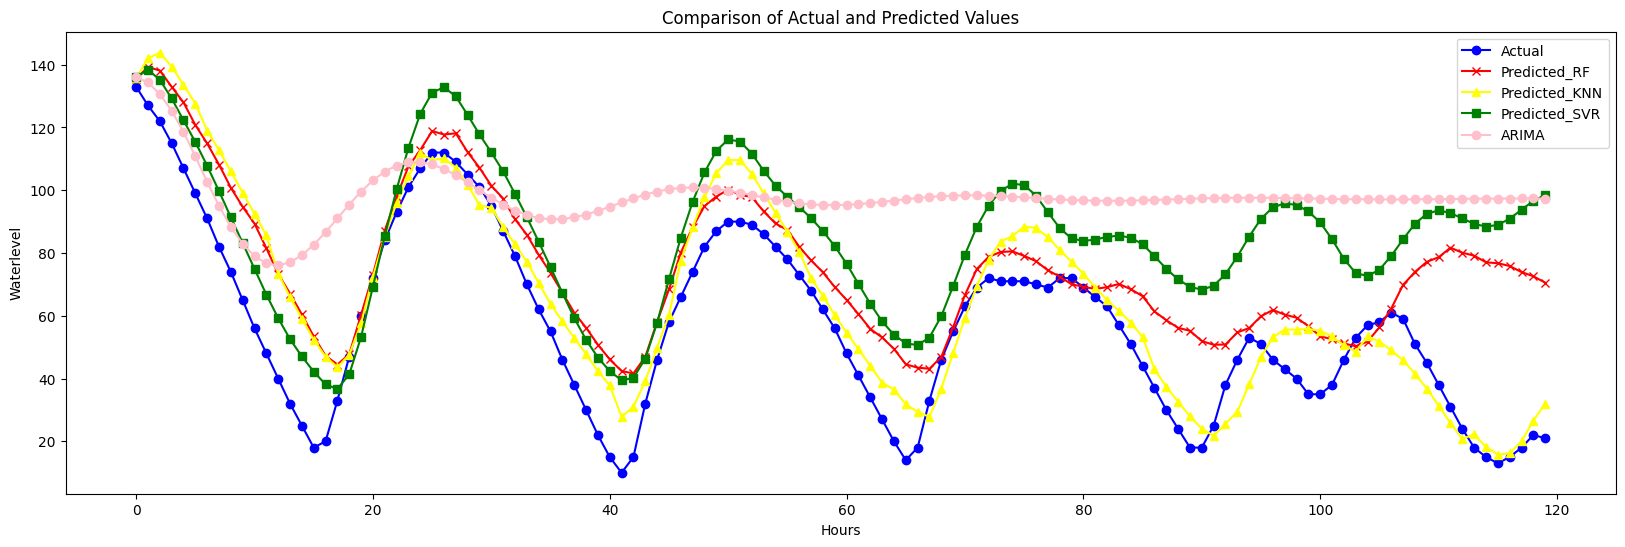

In [39]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(y_test_original[:hours], label='Actual', color='blue', marker='o')
    plt.plot(predict_RF[:hours], label='Predicted_RF', color='red', marker='x')
    plt.plot(y_test_pred_knn[:hours], label='Predicted_KNN', color='yellow', marker='^')
    plt.plot(y_test_pred[:hours], label='Predicted_SVR', color='green', marker='s')
    plt.plot(predictions_arima[:hours].flatten(), label='ARIMA', color='pink', marker='o')

    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Hours')
    plt.ylabel('Waterlevel')
    plt.legend()

    plt.show()